# Mathematical Underpinnings - Lab 10

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
from sklearn.preprocessing import scale

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [36]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [37]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [38]:
X = scale(X)
Y = scale(Y)

### a)

In [39]:
mod_lars = Lars(fit_intercept=False)
# fit
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

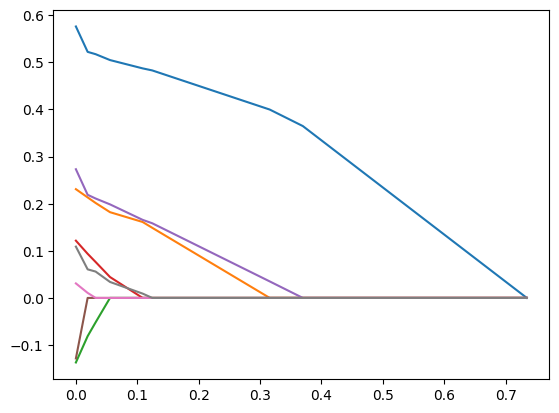

In [40]:
# plot
plt.plot(mod_lars.alphas_, mod_lars.coef_path_.T)
plt.show()

Order in which the variables are included in the model:

In [41]:
#for i in range(9):
pd.DataFrame(mod_lars.coef_path_).sort_values(ascending=False, by=[0, 1, 2, 3, 4, 5, 6, 7, 8]).index.values

array([0, 4, 1, 7, 3, 6, 5, 2], dtype=int64)

### b)

In [42]:
mod_lars.alphas_[0]

0.7344603262136732

In [43]:
vals = [(np.corrcoef(X[:, i], y=Y) - np.diag(np.ones([2]))).max() for i in range(X.shape[1])]
max(vals), np.argmax(vals)

(0.7344603262136737, 0)

### b1)

In [44]:
selected_variables = []

In [45]:
selected_variables.append(np.argmax(vals))

### b2)

In [46]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:, selected_variables], Y)

LinearRegression(fit_intercept=False)

### b3)

In [47]:
alphas = np.linspace(0, 1, 101)
y_hat = mod1.predict(X[:, selected_variables])

res_corr = np.zeros((X.shape[1], len(alphas)))
res_1 = np.zeros((len(Y), len(alphas)))
res_1 = Y[:, None] - alphas[None, :] * y_hat[:, None]
for i, alpha in enumerate(alphas):
    for j in range(X.shape[1]):
        res_corr[j, i] = np.corrcoef(X[:, j], res_1[:, i])[0, 1]
res_corr.shape

(8, 101)

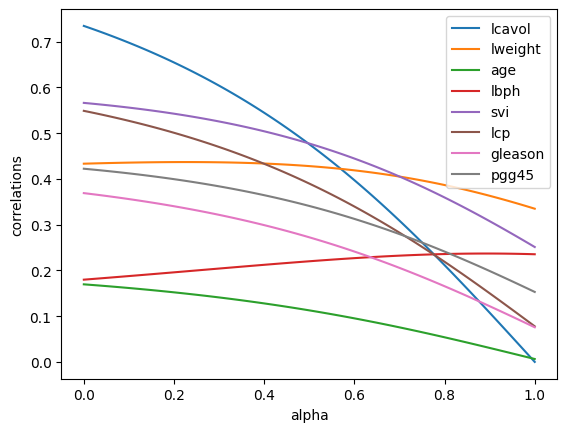

In [64]:
plt.figure()
plt.plot(alphas, res_corr.T)
plt.legend(df.columns[0:8])
plt.xlabel("alpha")
plt.ylabel("correlations")
plt.show()

lcavol blue line visualizes it

In [49]:
# plot


### b4)

svi purple line first crosses the blue line, so it will be added, alpha is around 0.5

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

In [50]:
# code
val = np.zeros((X.shape[1], len(alphas)))

for i in range(X.shape[1]):
    for j, alpha in enumerate(alphas):
        val[i, j] = np.std(Y) * np.corrcoef(X[:, i], Y)[0, 1] - np.std(y_hat) * alpha * np.corrcoef(X[:, i], y_hat)[
            0, 1]

In [51]:
# plot

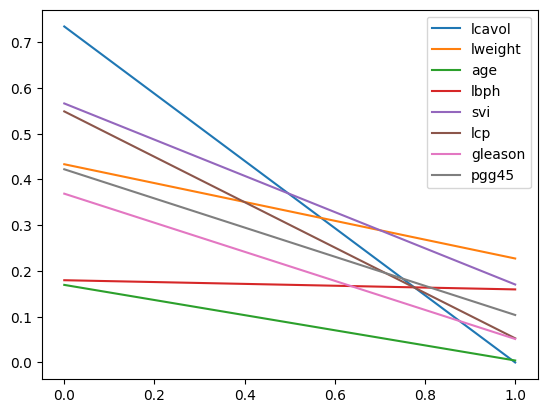

In [52]:
plt.plot(alphas, val.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()

In [53]:
last_var = selected_variables[-1]
new_var = np.argmin((np.nan_to_num(
    (np.std(Y) * np.corrcoef(X.T, Y)[last_var, -1] - np.std(Y) * np.corrcoef(X.T, Y)[:-1, -1]) / (
            np.std(y_hat) * np.corrcoef(X.T, y_hat)[last_var, -1] - np.std(y_hat) * np.corrcoef(X.T, y_hat)[:-1,
                                                                                    -1]), nan=1)))
new_var

C:\Users\Mati\AppData\Local\Temp\ipykernel_780\1817179275.py:2: RuntimeWarning: invalid value encountered in divide
  new_chosen_variable = np.argmin((np.nan_to_num((np.std(Y)* np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.std(Y)* np.corrcoef(X.T, Y)[:-1, -1]) / (np.std(y_hat)* np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.std(y_hat)* np.corrcoef(X.T, y_hat)[:-1, -1]), nan = 1)))


4

In [54]:
a_true = (np.std(Y) * np.corrcoef(X.T, Y)[last_var, -1]) - (np.std(Y) * np.corrcoef(X.T, Y)[:-1, -1])
a_pred = (np.std(y_hat) * np.corrcoef(X.T, y_hat)[last_var, -1]) - (np.std(y_hat) * np.corrcoef(X.T, y_hat)[:-1, -1])

gamma_2 = np.min(np.nan_to_num(a_true / a_pred, nan=1))
gamma_2

C:\Users\Mati\AppData\Local\Temp\ipykernel_780\1522073362.py:4: RuntimeWarning: invalid value encountered in divide
  gamma_2 = np.min(np.nan_to_num(a/b, nan = 1))


0.4967289013871957

### b6)

In [55]:
alpha2 = (np.std(Y) * np.corrcoef(X[:, new_var], Y)[0, 1]) - (
        np.std(y_hat) * gamma_2 * np.corrcoef(X[:, new_var], y_hat)[0, 1])
alpha2

0.3696326552610745

In [56]:
Y = Y - y_hat * gamma_2
selected_variables.append(new_var)
selected_variables

[0, 4]

### b7)

In [57]:
mod2 = LinearRegression(fit_intercept=False)
mod2.fit(X[:, selected_variables], Y)
mod2.coef_

array([0.24020136, 0.24020136])

### b8)

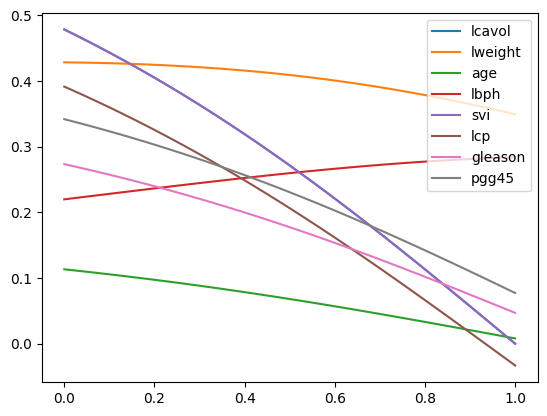

In [58]:
alphas = np.linspace(0, 1, 101)
y_hat = mod2.predict(X[:, selected_variables])
res = np.zeros((len(Y), len(alphas)))
for i, alpha in enumerate(alphas):
    res[:, i] = Y - alpha * y_hat
res_corr = np.zeros((X.shape[1], len(alphas)))
for i, alpha in enumerate(alphas):
    for j in range(X.shape[1]):
        res_corr[j, i] = np.corrcoef(X[:, j], res[:, i])[0, 1]
plt.plot(alphas, res_corr.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()

blue and purple lines correspond to the theorem

### b9)

around 0.15

### b10)

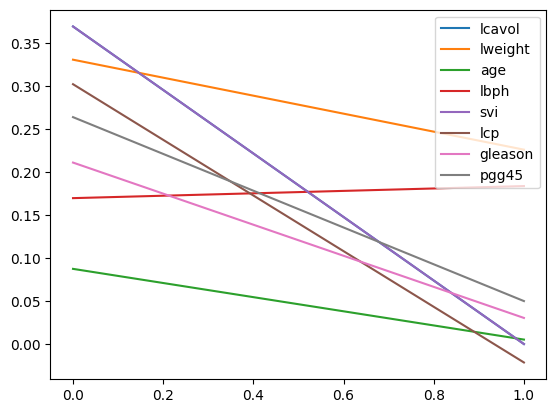

In [59]:
val = np.zeros((X.shape[1], len(alphas)))
for i in range(X.shape[1]):
    for j, alpha in enumerate(alphas):
        val[i, j] = (np.std(Y) * np.corrcoef(X[:, i], Y)[0, 1]) - (
                np.std(y_hat) * alpha * np.corrcoef(X[:, i], y_hat)[0, 1])
plt.plot(alphas, val.T)
plt.legend(df.columns[0:8], loc='upper right')
plt.show()

### b11)

In [62]:
a_true = np.std(Y) * np.corrcoef(X.T, Y)[last_var, -1] - np.std(Y) * np.corrcoef(X.T, Y)[:-1, -1]
a_pred = np.std(y_hat) * np.corrcoef(X.T, y_hat)[last_var, -1] - np.std(y_hat) * np.corrcoef(X.T, y_hat)[:-1, -1]

gamma_3 = np.min(np.nan_to_num(a_true / a_pred, nan=1))
gamma_3

C:\Users\Mati\AppData\Local\Temp\ipykernel_780\1693857511.py:4: RuntimeWarning: invalid value encountered in divide
  gamma_3 = np.min(np.nan_to_num(a/b, nan = 1))


0.14590879649354713

In [63]:
alpha3 = np.std(Y) * np.corrcoef(X[:, new_var], Y)[0, 1] - np.std(y_hat) * gamma_3 * np.corrcoef(X[:, new_var], y_hat)[
    0, 1]
alpha3

0.3156999993872168

In [65]:
r1 = Y - gamma_3 * y_hat

In [61]:
last_var = selected_variables[-1]
new_var = np.argmin((np.nan_to_num(
    (np.std(Y) * np.corrcoef(X.T, Y)[selected_variables[-1], -1] - np.std(r1) * np.corrcoef(X.T, r1)[:-1, -1]) / (
            np.std(y_hat) * np.corrcoef(X.T, y_hat)[selected_variables[-1], -1] - np.std(y_hat) * np.corrcoef(X.T,
                                                                                                              y_hat)[
                                                                                                  :-1, -1]),
    nan=1)))
df.columns[new_var]

svi


### c)

## Task 2

In [ ]:
X = pd.read_table("data/SRBCT_X.txt", sep=" ")
Y = pd.read_table("data/SRBCT_Y.txt", sep=" ")

X = np.array(X)
Y = np.array(Y)[:, 0]

In [ ]:
X = scale(X)
Y = Y - np.mean(Y)

### a)

In [ ]:
mod_lars = Lars(n_nonzero_coefs=80)
# fit

In [ ]:
# plot

In [ ]:
# the order

### b)

In [ ]:
mod_lassolars = LassoLars(alpha=0.15)
# fit

In [ ]:
# order

In [ ]:
# plot

### c)

In [ ]:
lasso_coef = np.zeros((X.shape[1], mod_lassolars.alphas_.shape[0]))

In [ ]:
for i in range(mod_lassolars.alphas_.shape[0]):
    mod_lasso = Lasso(alpha=mod_lassolars.alphas_[i])
    mod_lasso.fit(X, Y)

    lasso_coef[:, i] = mod_lasso.coef_

In [ ]:
# plot